# West Nile Virus Prediction

This data and challenge comes from [this kaggle competition](https://www.kaggle.com/c/predict-west-nile-virus/overview), and is a group project by [mtjericho](https://github.com/mtjericho), [yanglinaomi](https://github.com/yanglinaomi), and [nysk92](https://github.com/nysk92) (github profiles).  

## Problem Statement

The West Nile Virus ('WNV') is a disease most commonly spread by certain species of mosquitoes. Cases of West Nile Virus occur during mosquito season, which starts in the summer and continues through fall. 

Most people infected with the virus will not get sick. Around 20% may experience flulike symptoms. However, the virus can cause serious illness. According to the US Centers for Disease Control ('CDC'), less than 1% of people bitten by an infected mosquito will become severely ill. 

The number of WNV cases in an area could rise in any given year. This risk is why the Chicago Department for Public Health ('CDPH') established a surveillance and control program in 2004, which includes annual spraying.  

As data scientists, with the provided datasets, we would like to build a predictive model that can determine whether or not a particular area will have WNV-carrying mosquitoes. With such a model, CDPH can target mosquito-spraying efforts towards areas that pose the greatest risk, mitigating the potential of another outbreak. We also evaluate effectiveness of the current annual spray program.

## Executive Summary

To effectively prevent West Nile Virus breaking out during summer and fall, the CDPD needs a predictive model to detect locations where present West Nile Virus in advance. 

In this project, we will explore datasets that include information about weather, mosquito spray details, and the presence of the virus with location and time details. According to exploratory data analysis, some less relevant features are dropped and some feature engineering is done for helpful variables. 

We create and compared several models using different feature combinations. The models we tried include logistic regression, random forest, SVM and XGBoost. Our best model achieved an roc-auc score of 75%.

Analysing our best model's coefficients showed that certain weather features and the mosquito species were key features in predicting the presence of the virus. We also do a cost benefit analysis on the effectiveness and drawbacks of spraying to tackle the WNV problem.

Through our recommendations, we hope the CDPH can allocate its resource more  effectively towards preventing transmission of this potentially deadly virus. 

## Imports and Data Loading

In [129]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier, plot_importance

In [4]:
path = 'data/'
weather = pd.read_csv(path + 'weather.csv')
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
spray = pd.read_csv(path + 'spray.csv')

## Data Cleaning and Imputation

First we will look at the weather data, followed by the train & test data, then the spray data.

### Weather Data

The weather data contains data measured from two weather stations, with information such temperature and weather conditions.
The years in the weather data corresponds to the years in the train and test sets.

Convert date column to datetime.

In [5]:
weather['Date'] = pd.to_datetime(weather['Date'])

In [6]:
weather.sort_values(by='Date', inplace=True)

In [7]:
weather.reset_index(inplace=True)

In [8]:
weather.drop('index', axis=1, inplace=True)

Clean weather data based on provided weather documentation.

In [9]:
weather.replace('M', np.nan, inplace=True) # data with "M" are missing data
weather.replace('-', np.nan, inplace=True) # data with "-" are missing data

weather.replace('T', 0.00001, inplace=True) 
weather.replace('  T', 0.00001, inplace=True) 

For example, the Precip column contains 1577 "0" and 318 "T" values, T stands for Trace, which in weather terms is just a very small number that cannot be measured in standard units. T values will be replaced with an aribtarily determined small value of 0.000001 just to distinguish them from 0.
This will be an important feature as it is indicative of wet weather, which is favourable for mosquito breeding.

In [10]:
weather.shape

(2944, 22)

After some exploration of the values, we realised Station 2 was full of missing values, and Station 1 mostly provided the equivalent information whenever Station 2 was lacking.
We will keep only Station 1 values, dropping Station 2 values.

In [12]:
weather = weather[weather['Station']==1]

Drop Water1 column that contains all missing data.

In [13]:
weather.drop(columns='Water1', inplace=True)

Drop 'Depth' (only 1 value) and 'SnowFall' (99% 1 value) columns.

In [14]:
weather['Depth'].value_counts(normalize=True)

0    1.0
Name: Depth, dtype: float64

In [15]:
weather['SnowFall'].value_counts(normalize=True)

0.0      0.991168
1e-05    0.008152
0.1      0.000679
Name: SnowFall, dtype: float64

In [16]:
weather = weather.drop(columns=['Depth', 'SnowFall'])

Cast columns to correct numeric type.

In [17]:
weather_float_cols = ['Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
                      'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultDir', 'AvgSpeed']

Convert non-numeric columns to float, and imputed missing values (WetBulb, StnPressure and SeaLevel) with mean values.

We considered using imputing based forward filling (on previous day information) but found that imputing with mean yielded slightly better model performance. 

In [18]:
for col in weather_float_cols:
    weather[col] = weather[col].astype(float)
    weather[col] = weather[col].fillna(weather[col].mean(skipna=True))

Check for duplicates.

In [19]:
len(weather[weather.duplicated() == True])

0

### Train and Test Data

The train and test set contains geographical information such as address and coordinates of places where mosquito traps were set. There is information on the number of mosquitos found and whether the virus was detected in the train set, but not in the test set. The test set has an Id column that we need to preserve for the Kaggle submission.

In [20]:
train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [21]:
test.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'],
      dtype='object')

Convert date column to correct format.

In [22]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

Drop NumMosquitos column. The column is also not in test data so we cannot use this feature for prediction.

We considered doing a prediction to create this number but did not want to introduce more bias into the models by propgating errors in predicting mosquito numbers. Also, based on EDA in a separate working notebook, we did not see a strong correlation between NumMosquitos and the presence of the virus. 

In [23]:
train = train.drop(columns='NumMosquitos')

Check for duplicates.

In [24]:
len(test[test.duplicated()==True])

0

In [25]:
len(train[train.duplicated()==True])

1896

In [26]:
train = train.drop_duplicates()

### Spray data

The spray dataset has 14,835 entries and 4 columns, namely Date, Time, Latitude and Longitude. There are 584 null values in the Time column and when we look at these null values, we noticed that the null values are all from spray data on 2011-09-07. 

In [27]:
spray['Date'] = pd.to_datetime(spray['Date'])

In [28]:
spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [29]:
spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [30]:
spray.drop('Time', axis=1, inplace=True)

In [31]:
spray.duplicated().sum()

541

In [32]:
# Drop duplicates
spray.drop_duplicates(inplace=True)

In [39]:
spray['Date'].map(lambda x: x.year).unique()

array([2011, 2013])

In [40]:
test['Date'].map(lambda x: x.year).unique()

array([2008, 2010, 2012, 2014])

Most crucially, there is no spray data corresponding to the test data, so we will not use the spray data for modelling.

## Merge weather data

In [36]:
train = train.merge(weather, on='Date')
test = test.merge(weather, on='Date')

<br>
<br>

## Exploratory Data Analysis 

### Explore Species

The species that is most common is Pipiens / Restuans. Pipiens has the highest probability of WnvPresent. Followed by Restuans. The rest of the species does not cause WnvPresent from the data.

This corresponds to [the following report](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2929059/) on species transmission of the WNV.

/Users/neilyap/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


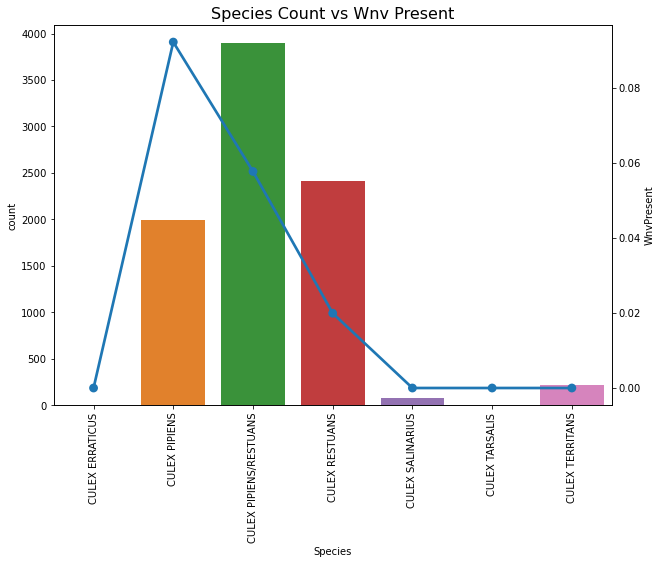

In [41]:
tmp = pd.crosstab(train['Species'],train['WnvPresent'],normalize='index')
tmp.columns = ['WnvAbsent','WnvPresent']

fig,ax = plt.subplots(figsize=(10,7))
ax1 = sns.countplot(train['Species'], ax=ax, order = list(tmp.index))
ax.tick_params(axis='x',rotation=90)
ax2 = ax1.twinx()
sns.pointplot(x = tmp.index, y = tmp['WnvPresent'], ax=ax2, order = list(tmp.index))
plt.title('Species Count vs Wnv Present', size=16)
plt.show()

The coloured bars correspond to the count of that species in the training data, while the blue line plots their mean presence of WNV. 

As seen in the plot, it is mainly Culex Pipiens and Restuans that transmit the virus, and are also the highest occuring species in the data. These observations will be encoded in the Feature Engineering section below.

### Explore Trap Data

From the following Trap vs Wnv Present ratio plots, we can observe that some Traps tend to correspond to a higher Wnv Present ratio. 
We will encode the Trap data to reflect their different tiers of virus presence.

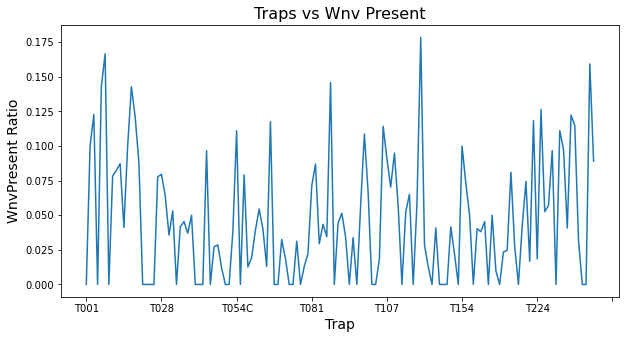

In [42]:
plt.figure(figsize=(10,5))
plt.title('Traps vs Wnv Present', size=16)
plt.xlabel('Trap No', size=14)
plt.ylabel('WnvPresent Ratio', size=14)
train.groupby('Trap')['WnvPresent'].mean().plot();

From an initial plot, we do not see a clear trend of how traps correspond to virus presence, but we do see there is a lot of variance for virus presence between the different traps.

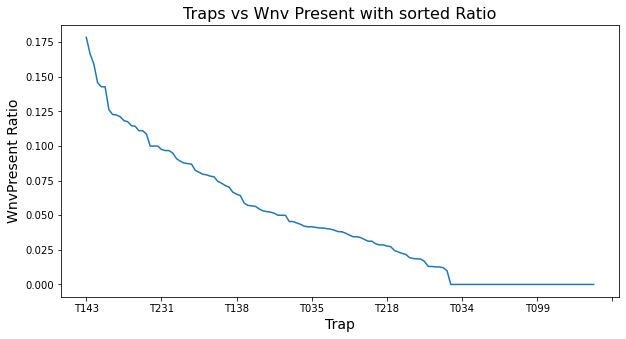

In [43]:
plt.figure(figsize=(10,5))
plt.title('Traps vs Wnv Present with Sorted Ratio', size=16)
plt.xlabel('Trap No', size=14)
plt.ylabel('WnvPresent Ratio', size=14)
train.groupby('Trap')['WnvPresent'].mean().sort_values(ascending=False).plot();

By ordering according to mean presence of the virus instead of simply by trap number, we see a clearer pattern on how to segment traps into different tiers of virus presence.

This relationship will be encoded in the Feature Engineering section below.

### Explore Relations Between Location and Virus

We try to determine if the location features could be helpful for predicting the presence of the virus.

Text(0, 0.5, 'Long')

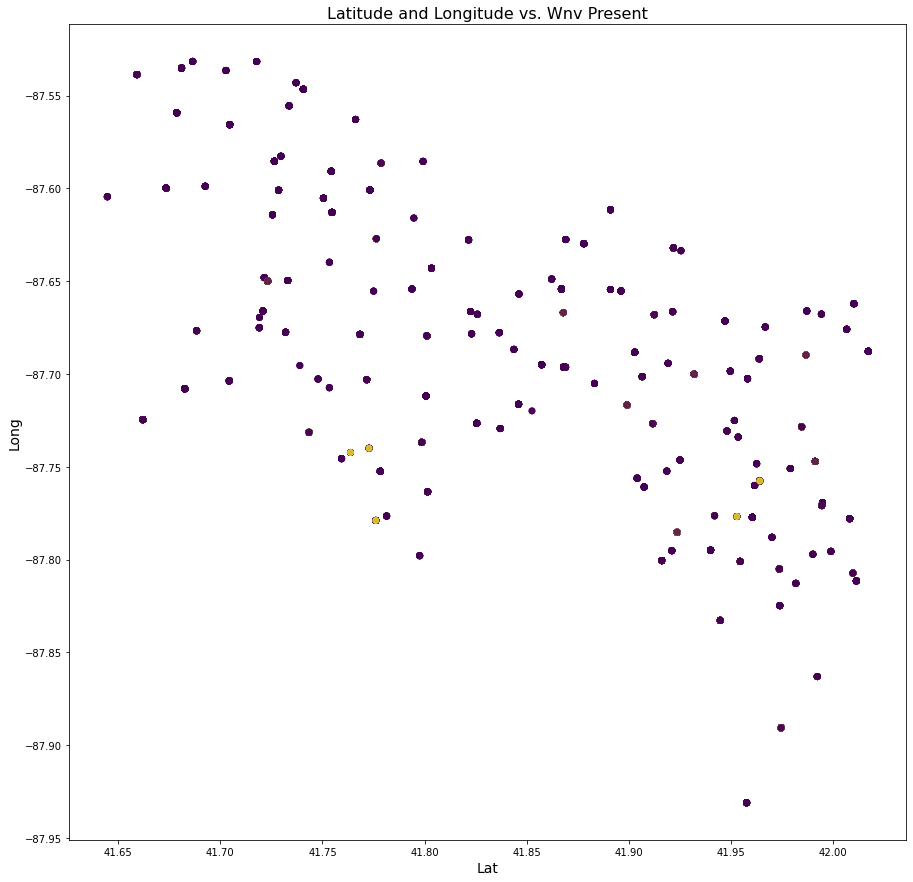

In [46]:
plt.figure(figsize=(15,15))
plt.scatter(data=train, x='Latitude', y='Longitude', 
            c='WnvPresent', alpha=0.8, marker='o')
plt.title('Latitude and Longitude vs. Wnv Present', size=16)
plt.xlabel('Lat', size=14)
plt.ylabel('Long', size=14)

Based on the scatterplot above, we do see that there some locations that appear as small clusters of virus presence (yellow). 

However, with the scatterplot, locations with more occurences of the virus will stand out (as the yellow points will stand out against the dark points).

We will use a map visualisation to better understand the virus presences based just on whether the virus was present or not.

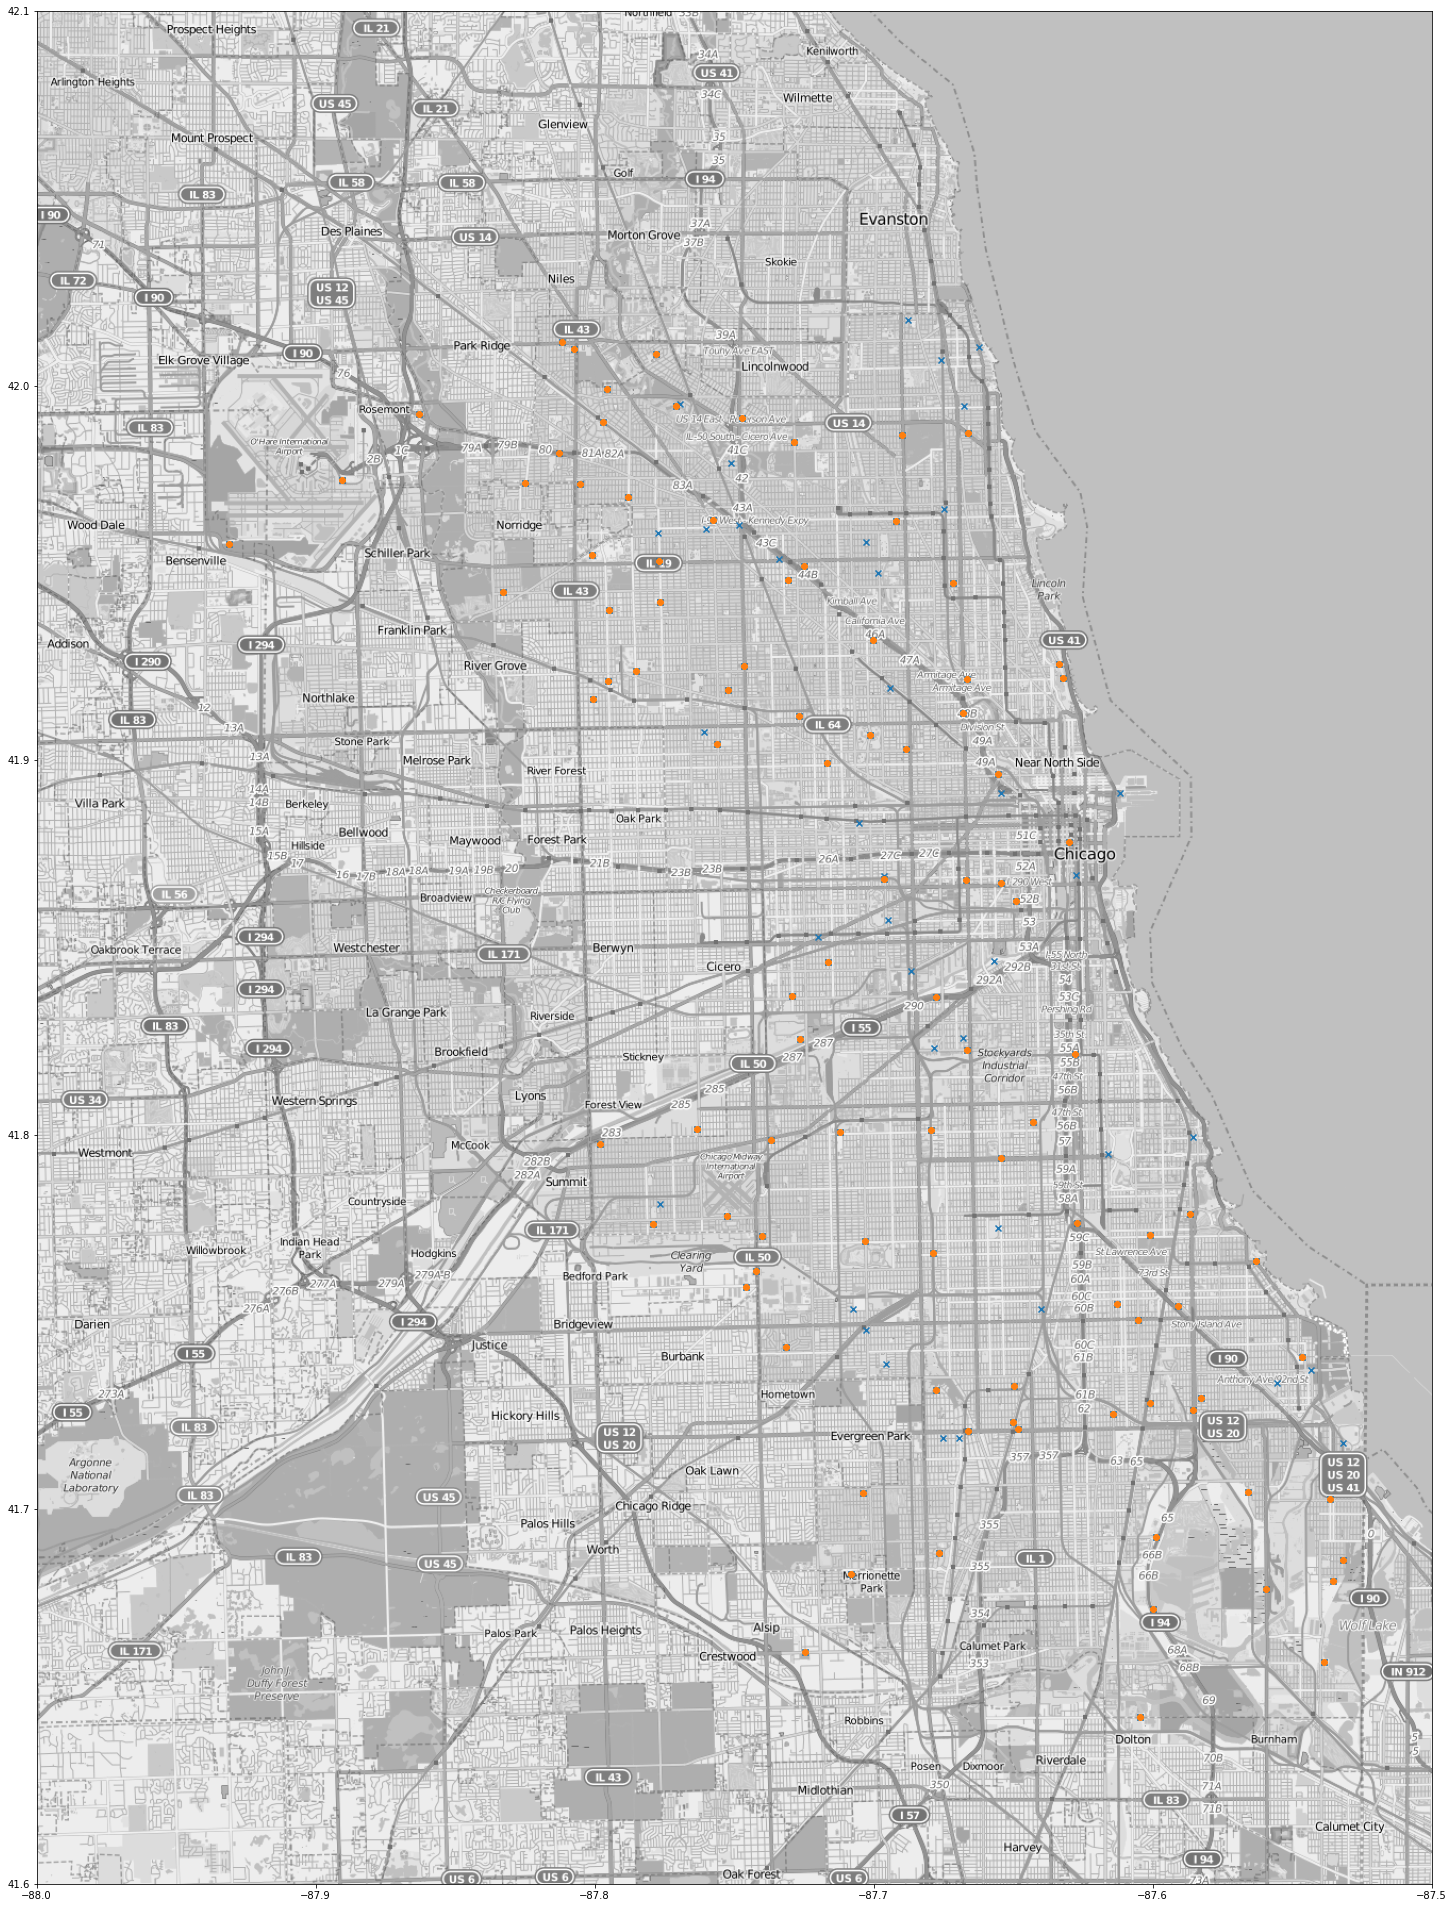

In [48]:
# this map rendering code is apapted from the code provided in the Kaggle competition
mapdata = np.loadtxt('resources/mapdata_copyright_openstreetmap_contributors.txt')
traps = train[['Date','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(25,35))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = traps[['Longitude', 'Latitude', 'WnvPresent']].drop_duplicates()
wnv_locations = locations[locations['WnvPresent']==1]
locations = locations.values
wnv_locations = wnv_locations.values
plt.scatter(locations[:,0], locations[:,1], marker='x')
plt.scatter(wnv_locations[:,0], wnv_locations[:,1], marker='o')

Locations where the virus was present are marked in orange.

We had expected to see that perhaps the virus would be present in areas near water bodies or greenery but the data does not show this. 

### Exploration of Location and Virus Relation, with Spray Data

We will next try to incorporate the magnitude of virus detections in another plot, and also make use of the spray data to hopefully see a stronger trend between location and virus.

The assumption is that spraying would correspond to places the authorities deemed had a stronger presence of the virus, thereby providing better signal for any potential location trends.

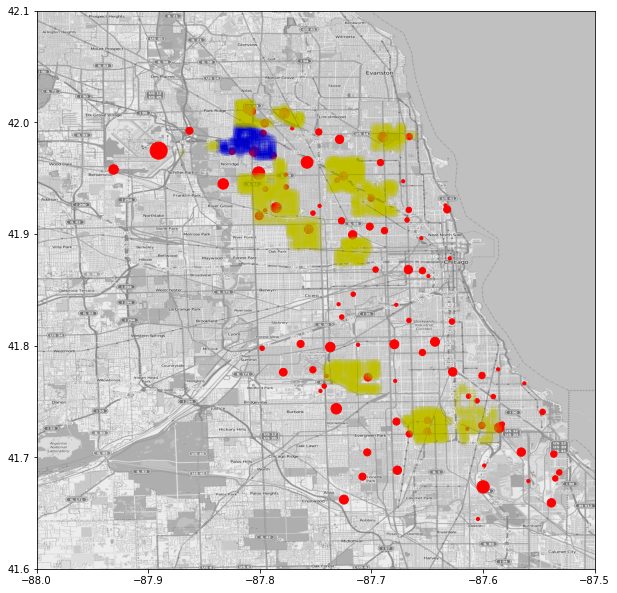

In [59]:
# Load map data
origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

mapdata = np.loadtxt('resources/mapdata_copyright_openstreetmap_contributors.txt')

# traps with WnvPresent
train_wnv = train[train['WnvPresent']==1]

#For each lat and long, calculate the count of WnvPresent to indicate
# cluster in map with high WnvPresent possibility
count = train_wnv.groupby(['Latitude', 'Longitude'])['WnvPresent'].count()
train_wnv_count=pd.DataFrame(count).reset_index(level=['Latitude', 'Longitude'])

#Seperate 2011 and 2013 to check spray the same locations during these two years
spray = spray[spray['Latitude'] < 42.3] #outliers excluded
spray['Year'] = spray['Date'].map(lambda x: x.year)
spray_2011=spray[spray['Year']==2011]
spray_2013=spray[spray['Year']==2013]

# # generate plot
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
plt.scatter(train_wnv_count['Longitude'], train_wnv_count['Latitude'], c='r', s=train_wnv_count['WnvPresent']*10, marker='o')
plt.scatter(x='Longitude', y='Latitude', data=spray_2011, c='b', marker='s', alpha=0.02)
plt.scatter(x='Longitude', y='Latitude', data=spray_2013, c='y', marker='s', alpha=0.03)

Interestingly, the areas near O'Hare International Airport had a high proability of WNV presence. However,just based on the spray data in year 2011 and 2013, O'Hare International Airport was not sprayed. It could either be due to inaccurate data, or that might be some regulatory restrictions hindering spraying at airports.

Besides O'Hare International Airport, there are still other locations with west nile virus present, which are highlighted as red dots in the map (larger red dot means higher occurence of the WNV being present. We suggest CDPH to look deeper into these locations during spraying.

In [51]:
train[['WnvPresent', 'Latitude', 'Longitude']].corr()['WnvPresent']

WnvPresent    1.000000
Latitude      0.030907
Longitude    -0.074075
Name: WnvPresent, dtype: float64

We still do not observe any obvious geographical clusters for the virus, they are all quite evenly spread out. The low pearson correlation between the virus presence and locations also confirm this.

We could possibly encode a feature related to being near O'Hare, but that would be a very abitrary feature that would not fare well for general predictions (e.g. if the airport ramps up efforts to clean out the mosquitos, this feature will just be noise).

We decide to drop location columns. 

In [52]:
address_cols = ['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy']

In [53]:
train.drop(columns=address_cols, inplace=True)

In [54]:
test.drop(columns=address_cols, inplace=True)

### Explore Year/Month Variables

In [55]:
train['Month'] = train['Date'].map(lambda x: x.month)

In [56]:
train['Year'] = train['Date'].map(lambda x: x.year)

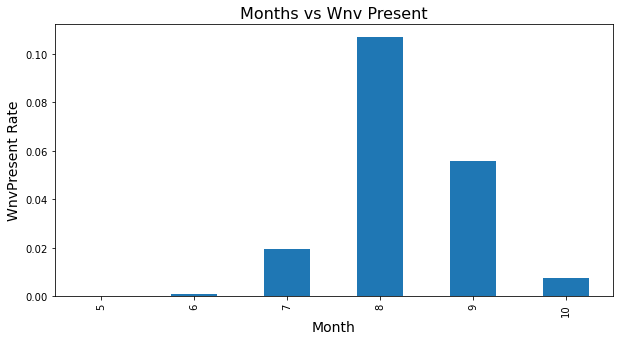

In [57]:
plt.figure(figsize=(10,5))
plt.title('Months vs Wnv Present', size=16)
plt.xlabel('Months', size=14)
plt.ylabel('WnvPresent Rate', size=14)
train.groupby('Month')['WnvPresent'].mean().plot(kind='bar');

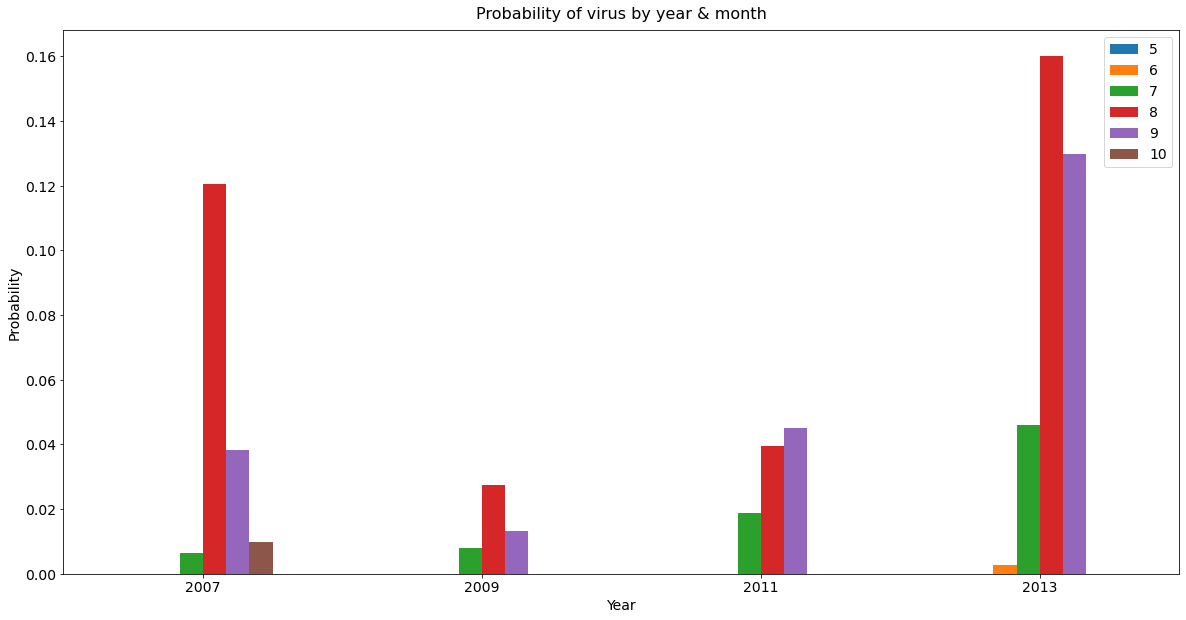

In [58]:
# Highest percentage of virus occuring in Aug, Sep 
train.groupby(['Year','Month'])['WnvPresent'].mean().unstack().plot(kind='bar',figsize=(20,10))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Probability of virus by year & month', fontsize=16, y=1.01)
plt.ylabel('Probability', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

Makes sense that summer months correspond to high presence of virus as it is breeding season for mosquitos. The virus tends to peak in the middle of the summer in August for most years. As such, we will encode months to an ordinal variable in the Feature Engineering section below, but will not use years.

### Explore Tavg & DewPoint

The below graphs shows that when average temperature is higher than 65 °Fahrenheit and the DewPoint value is higher than 53 degrees, there is higher chance of the virus being present. 

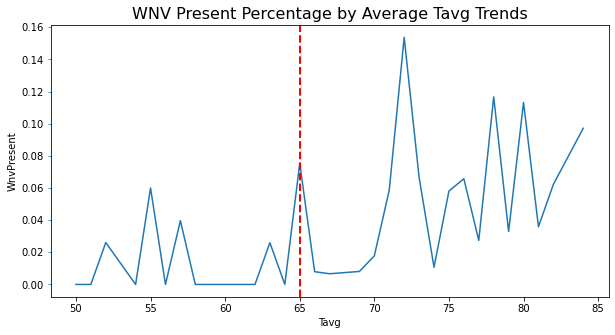

In [63]:
# From the above graph, we can see that Tavg above 65 degrees,
# there is significantly more WNV cases.
plt.figure(figsize=(10,5))
color = 'tab:blue'
plt.title('WNV Present Percentage by Average Tavg Trends', fontsize=16)
sns.lineplot(x='Tavg', y='WnvPresent', data = train, color=color, ci=None)
plt.tick_params(axis='y', color=color)
plt.axvline(x=65, color='red', linestyle='--', linewidth=2)
plt.show()

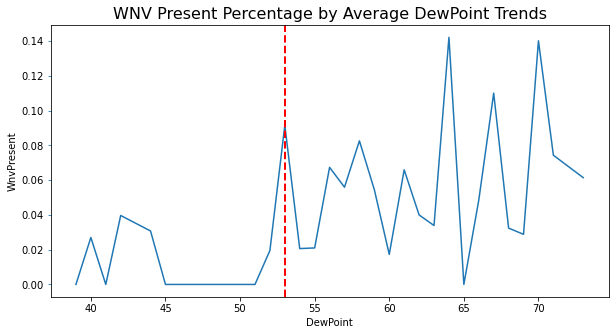

In [64]:
# From the above graph, we can see that dewpoint above 53 degrees,
# there is significantly more WNV cases.
plt.figure(figsize=(10,5))
color = 'tab:blue'
plt.title('WNV Present Percentage by Average DewPoint Trends', fontsize=16)
sns.lineplot(x='DewPoint', y='WnvPresent', data = train, color=color, ci=None)
plt.tick_params(axis='y', color=color)
plt.axvline(x=53, color='red', linestyle='--', linewidth=2)
plt.show()

## Feature Engineering

### Encode for Trap 

As covered in the EDA above, we will encode the traps into different ordinal categories based on their corresponding presence to the virus.

In [65]:
trap_scores = train.groupby('Trap')['WnvPresent'].mean().sort_values(ascending=False)

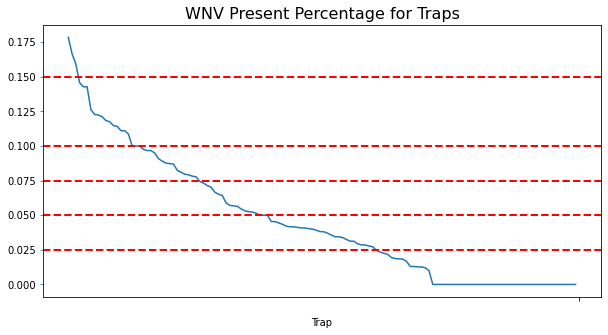

In [87]:
plt.figure(figsize=(10,5))
color = 'tab:blue'
plt.title('WNV Present Percentage for Traps', fontsize=16)
sns.lineplot(y=trap_scores.values, x=trap_scores.index, color=color, ci=None)
plt.tick_params(axis='y', color=color)
plt.xticks('x', ' ')
plt.axhline(0.15, color='red', linestyle='--', linewidth=2)
plt.axhline(0.1, color='red', linestyle='--', linewidth=2)
plt.axhline(0.075, color='red', linestyle='--', linewidth=2)
plt.axhline(0.05, color='red', linestyle='--', linewidth=2)
plt.axhline(0.025, color='red', linestyle='--', linewidth=2)
plt.show()

In [88]:
trap_map = {}
for k,v in trap_scores.items():
    if v >= 0.15:
        trap_map[k] = 5
    elif v >= 0.1:
        trap_map[k] = 4
    elif v >= 0.075:
        trap_map[k] = 3
    elif v >= 0.05:
        trap_map[k] = 2
    elif v >= 0.025:
        trap_map[k] = 1
    else:
        trap_map[k] = 0

In [89]:
train['Trap'] = train['Trap'].map(trap_map)

In [91]:
test['Trap'] = test['Trap'].map(trap_map)

In [92]:
# for test set fill trap numbers not found in train set using median category
test['Trap'].fillna(2, inplace=True)

### Encode for Month 

As covered in the EDA above, we will encode month data to reflect a high value for being in the peak of summer (August) and lower values for the other summer months as they move away from August. This corresponds to the relation we saw with the virus presence in the EDA.

In [93]:
month_map = {
    8: 20,
    9: 12,
    7: 4,
    10: 2,
    6: 1,
    1: 0, 2: 0, 3: 0, 4: 0, 5: 0,
    11: 0, 12: 0
}

# everything else 0

In [94]:
train['MonthScore'] = train['Month'].map(month_map)

In [95]:
test['Month'] = test['Date'].map(lambda x: x.month)

In [96]:
test['MonthScore'] = test['Month'].map(month_map)

In [97]:
train.drop('Month', axis=1, inplace=True)

In [98]:
test.drop('Month', axis=1, inplace=True)

### Encoding for Species

As seen in the EDA, there are two species that correspond to relatively higher virus presence. 
We will encode 2 if CULEX PIPIENS/RESTUANS, 3 for PIPIENS, 1 for RESTUANS and for everything else, 0.
Only these mentioned species have Wnv=1. Pipiens gets a higher score as [reports show that it is more contagious for the WNV](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2929059/).

In [99]:
train.Species.value_counts()

CULEX PIPIENS/RESTUANS    3899
CULEX RESTUANS            2409
CULEX PIPIENS             1996
CULEX TERRITANS            216
CULEX SALINARIUS            83
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [100]:
test.Species.value_counts()

CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
CULEX PIPIENS             14521
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
CULEX ERRATICUS           14345
UNSPECIFIED CULEX         14345
Name: Species, dtype: int64

In [101]:
mosq_map = {
    'CULEX PIPIENS/RESTUANS': 2,
    'CULEX RESTUANS': 1,
    'CULEX PIPIENS': 3,
    'CULEX TERRITANS': 0,
    'CULEX SALINARIUS': 0,
    'CULEX TARSALIS': 0,
    'CULEX ERRATICUS': 0,
    'UNSPECIFIED CULEX': 2
}

In [102]:
train['Species'] = train['Species'].map(mosq_map)

In [103]:
train.Species.value_counts()

2    3899
1    2409
3    1996
0     306
Name: Species, dtype: int64

In [104]:
test['Species'] = test['Species'].map(mosq_map)

In [105]:
test.Species.value_counts()

0    57398
2    29704
1    14670
3    14521
Name: Species, dtype: int64

### Create Lag Features

Since mosquito has a 1-2 week life cycle, we try out some timelags to see if the correlation is stronger to the target with each lag.

We try a lag of 1 day, 1 week and 2 weeks.

In [106]:
for lags in (1, 7, 14):
    for col in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb']:
        train[f'{col}_lag_{lags}'] = train[col].shift(lags)

### Create Day Length (in minutes) Feature
This feature is created from deducting the Sunrise from Sunset Values.

In [107]:
train['DayInMins'] = ((train['Sunset'] - train['Sunrise'])/100)*60
test['DayInMins'] = ((test['Sunset'] - test['Sunrise'])/100)*60

### Encode CodeSum to IsRain
We convert the very messy Code Sum feature to information about rain, which we deem will be relevant to mosquito breeding.

In [108]:
# hot encode for CodeSum column
# encode as 1 for rain related codes and 0 for others
# rain related codes
#TS THUNDERSTORM
#GR HAIL
#RA RAIN
#DZ DRIZZLE
#SH SHOWER
rain_list=['TS', 'GR', 'RA', 'DZ', 'SH']
for idx, row in train.iterrows():
    if any(item in train.at[idx,'CodeSum'] for item in rain_list):
        train.at[idx, 'IsRain']=1
    else:
        train.at[idx, 'IsRain']=0

In [109]:
rain_list=['TS', 'GR', 'RA', 'DZ', 'SH']
for idx, row in test.iterrows():
    if any(item in test.at[idx,'CodeSum'] for item in rain_list):
        test.at[idx, 'IsRain']=1
    else:
        test.at[idx, 'IsRain']=0

In [110]:
train.drop('CodeSum', axis=1, inplace=True)
test.drop('CodeSum', axis=1, inplace=True)

## Feature Selection

### Explore correlation between features and target

In [111]:
abs(train.corr()[['WnvPresent']]).sort_values(by='WnvPresent', ascending=False)

WnvPresent
WnvPresent         1.000000
MonthScore         0.186121
Trap               0.171282
Species            0.123341
Sunrise            0.096179
DewPoint           0.096124
DewPoint_lag_1     0.095385
DewPoint_lag_14    0.094724
WetBulb            0.094166
WetBulb_lag_1      0.093698
WetBulb_lag_14     0.092466
DewPoint_lag_7     0.092253
WetBulb_lag_7      0.089764
Tmin               0.086730
Tmin_lag_1         0.084910
Tmin_lag_14        0.083847
Tmin_lag_7         0.081475
Tavg               0.079215
Tavg_lag_1         0.078781
Tavg_lag_14        0.076129
Cool               0.075605
DayInMins          0.074981
Tavg_lag_7         0.073997
Depart             0.063704
Tmax_lag_1         0.062129
Tmax               0.061218
Heat               0.058976
Sunset             0.058570
Tmax_lag_14        0.058232
Tmax_lag_7         0.056318
ResultSpeed        0.055551
Year               0.042496
AvgSpeed           0.035324
IsRain             0.030431
PrecipTotal        0.025936
ResultDir          0.009709
StnPressure        0.003302
SeaLevel           0.002164
Station                 NaN

From the correlation coefficients, we see that the original weather variables without the time lags show stronger correlation to the target. We will drop the created lag features.

In a separate rough notebook, we also tested models using the lag 1 feature and it resulted in a weaker performance than using original variables without lag.

In [112]:
lag_cols = [col for col in train.columns if 'lag_' in col]

In [113]:
train.drop(columns=lag_cols, inplace=True)

### Drop Columns with Poor Correlation

Variables related to the physical weather station will be dropped as it does not make sense that it would affect mosquito breeding. SeaLevel also seems too remote to make sense to use.

In [114]:
to_drop = ['Station', 'StnPressure', 'SeaLevel']

In [115]:
train.drop(columns=to_drop, inplace=True)

In [116]:
test.drop(columns=to_drop, inplace=True)

Drop date columns, the month feature will be the key temporal feature, as summer months are mosquito breeding season.

In [117]:
train.drop(columns='Date', inplace=True)

In [118]:
train.drop(columns='Year', inplace=True)

In [119]:
test.drop(columns='Date', inplace=True)

In [120]:
test.columns

Index(['Id', 'Species', 'Trap', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'PrecipTotal',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'MonthScore', 'DayInMins',
       'IsRain'],
      dtype='object')

In [121]:
train.columns

Index(['Species', 'Trap', 'WnvPresent', 'Tmax', 'Tmin', 'Tavg', 'Depart',
       'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'PrecipTotal', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'MonthScore',
       'DayInMins', 'IsRain'],
      dtype='object')

We are now satisfied with our features, and will proceed to training models.

<br>
<br>

## Modelling

### Create Train Data from Selected Variables

In [125]:
variables = ['MonthScore', 'Species', 'DewPoint', 'WetBulb', 'Tmin', 'Tavg', 'Cool', 'Sunrise', 'Sunset', 'Depart',
             'Tmax', 'Heat', 'ResultSpeed', 'IsRain', 'Trap', 'PrecipTotal', 'AvgSpeed', 'DayInMins']

In [126]:
X = train[variables]
y = train['WnvPresent']

<AxesSubplot:title={'center':'Heat map for X Features Correlation with West Nile Virus '}>

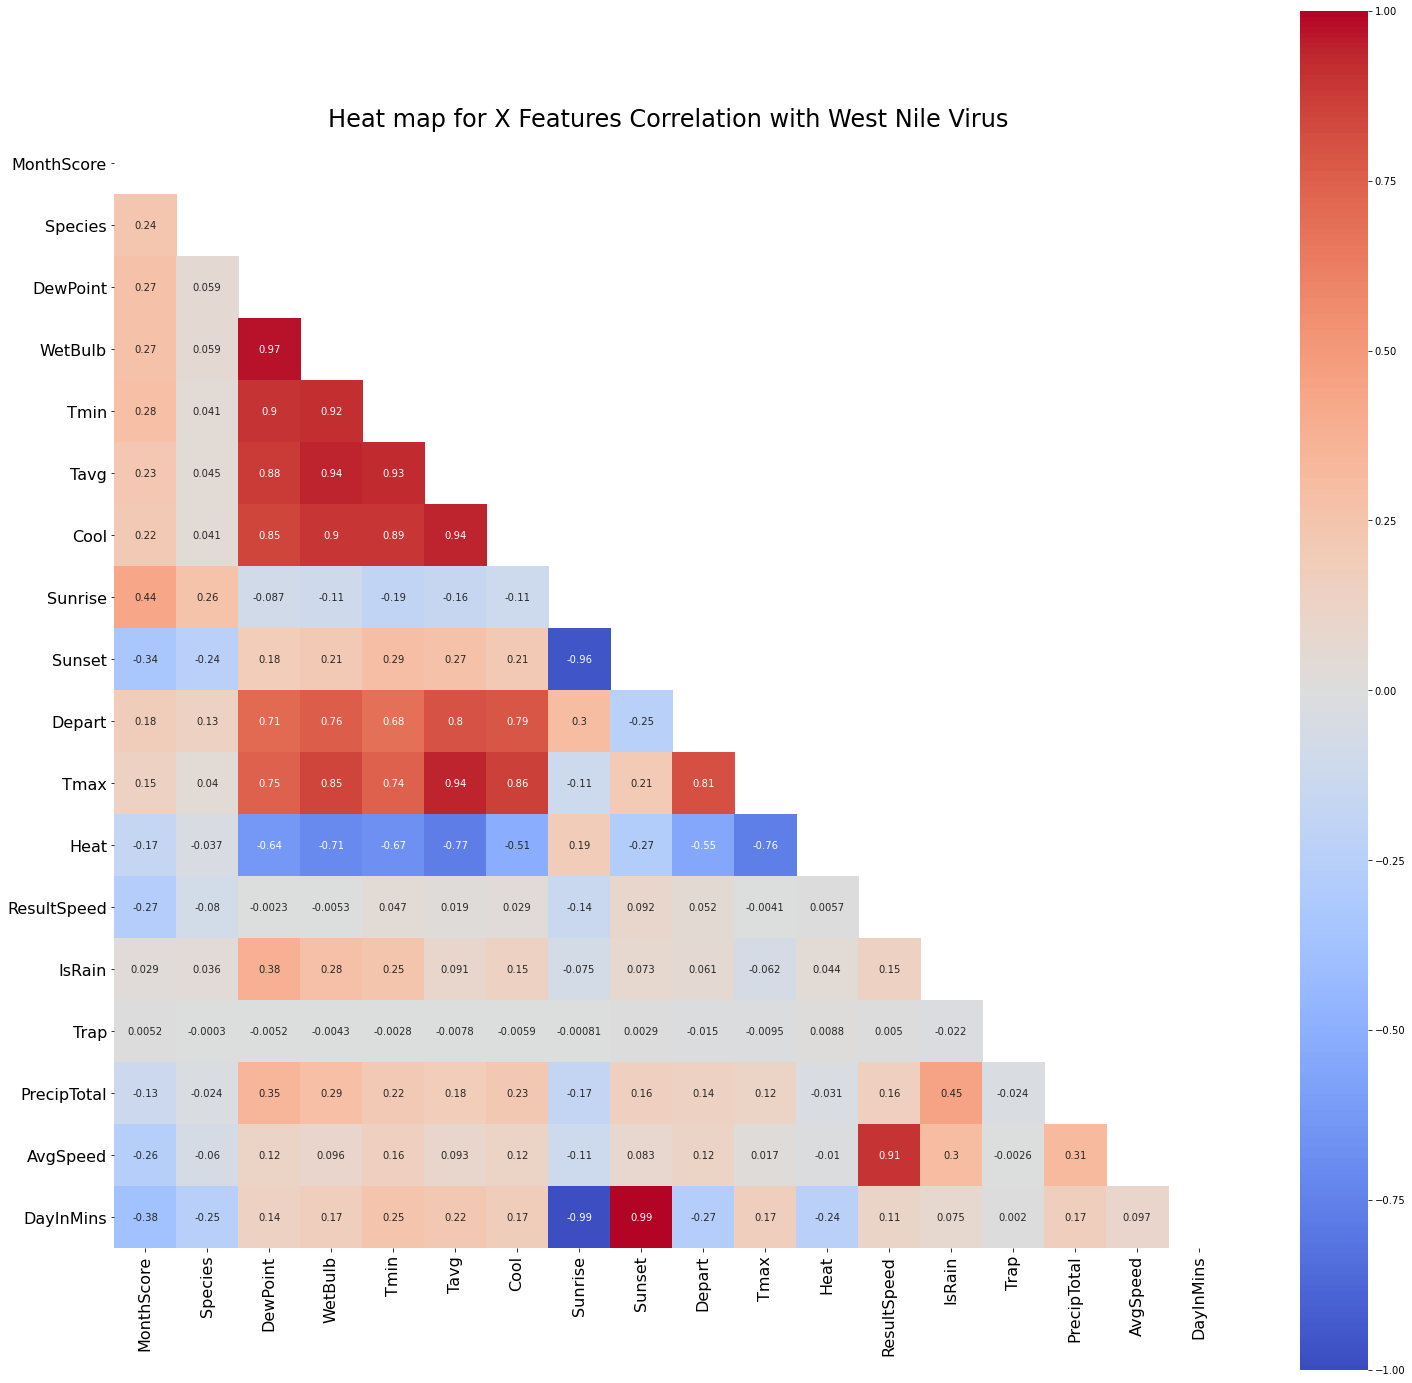

In [127]:
plt.figure(figsize=(25,25))
plt.title('Heat map for X Features Correlation with West Nile Virus ', size=24)
plt.xticks(size=16)
plt.yticks(size=16)
matrix = np.triu(X.corr())
sns.heatmap(X.corr(), mask= matrix, square=True, vmin=-1,vmax=1, annot = True, cmap = 'coolwarm')

We observe multicolinearity in our selected variables, evidenced by the two patches of dark red we see near the top, and the lines of blue we see in the Heat row.

We will proceed with these features and allow for the models to handle the colinearities.

### Train Val Split

split out hold out set

In [128]:
y.value_counts(normalize=True)

0    0.946922
1    0.053078
Name: WnvPresent, dtype: float64

We observe a very imbalanced distribution of our target class, and will use SMOTE to address this.

In [130]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

#### Create Results DataFrame

In [151]:
results = pd.DataFrame(columns=['Classifier', 'Hyperparams', 
                                'Train ROC AUC', 'Val ROC AUC',
                                'Test ROC AUC'])

### Logistic Regression

In [131]:
pipe_lr = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('logreg', LogisticRegression(max_iter=200))
    ])

In [132]:
pipe_lr_params = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    'sampling__k_neighbors': [3, 5],
    'logreg__C': [0.1, 0.5, 1]
}

In [133]:
grid_lr = GridSearchCV(pipe_lr, pipe_lr_params, scoring='roc_auc', cv=2, verbose=3,n_jobs=-1)

In [134]:
grid_lr.fit(X_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('sampling', SMOTE()),
                                       ('logreg',
                                        LogisticRegression(max_iter=200))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.1, 0.5, 1],
                         'sampling__k_neighbors': [3, 5],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             scoring='roc_auc', verbose=3)

#### evaluation of model on train data

In [135]:
grid_lr.best_score_

0.8324574010211974

In [136]:
grid_lr.score(X_train, y_train)

0.8402948449813123

In [137]:
grid_lr.score(X_val, y_val)

0.8429312614542732

In [138]:
roc_auc_score(y_val, grid_lr.predict(X_val))

0.7445299123237226

In [139]:
print(classification_report(y_train, grid_lr.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.75      0.85      6114
           1       0.15      0.81      0.26       343

    accuracy                           0.75      6457
   macro avg       0.57      0.78      0.55      6457
weighted avg       0.94      0.75      0.82      6457



In [140]:
print(classification_report(y_val, grid_lr.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      2039
           1       0.14      0.75      0.23       114

    accuracy                           0.74      2153
   macro avg       0.56      0.74      0.54      2153
weighted avg       0.94      0.74      0.81      2153



In [141]:
grid_lr

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('sampling', SMOTE()),
                                       ('logreg',
                                        LogisticRegression(max_iter=200))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.1, 0.5, 1],
                         'sampling__k_neighbors': [3, 5],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             scoring='roc_auc', verbose=3)

In [153]:
results = results.append(
    {'Classifier': 'Logistic Regression', 
     'Hyperparams': grid_lr.best_params_, 
     'Train ROC AUC': round(roc_auc_score(y_train, grid_lr.predict(X_train)), 
                          2), 
     'Val ROC AUC': round(roc_auc_score(y_val, grid_lr.predict(X_val)), 
                          2)},
    ignore_index=True)

### XGBoost

In [142]:
pipe_xg = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('xgb', XGBClassifier())
    ])

In [143]:
pipe_xg_params = {
    'sampling__sampling_strategy': ['minority', 'auto'],
    'sampling__k_neighbors': [3, 5],
#     'xgb__learning_rate': [0.01, 0.1],
#     'xgb__n_estimators': [100, 1000],
#     'xgb__subsample': [0.5, 0.7, 1],
    'xgb__max_depth': [2, 5, 10],
    'xgb__scale_pos_weight': [10, 18]
}

In [144]:
grid_xg = GridSearchCV(pipe_xg, pipe_xg_params, scoring='roc_auc', cv=2, verbose=3,n_jobs=-1)

In [145]:
grid_xg.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


/Users/neilyap/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:40:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('sampling', SMOTE()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                           

#### evaluation of model on train data

In [166]:
grid_xg.best_score_

0.8452571586165942

In [167]:
grid_xg.score(X_val, y_val)

0.8734888963458178

In [168]:
roc_auc_score(y_val, grid_xg.predict(X_val))

0.7919280176901301

In [169]:
print(classification_report(y_train, grid_xg.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.72      0.83      6114
           1       0.15      0.90      0.26       343

    accuracy                           0.73      6457
   macro avg       0.57      0.81      0.55      6457
weighted avg       0.95      0.73      0.80      6457



In [170]:
print(classification_report(y_val, grid_xg.predict(X_val)))

              precision    recall  f1-score   support

           0       0.99      0.70      0.82      2039
           1       0.14      0.89      0.24       114

    accuracy                           0.71      2153
   macro avg       0.57      0.79      0.53      2153
weighted avg       0.95      0.71      0.79      2153



In [171]:
grid_xg.best_params_

{'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'minority',
 'xgb__max_depth': 2,
 'xgb__scale_pos_weight': 10}

In [155]:
results = results.append(
    {'Classifier': 'XG Boost', 
     'Hyperparams': grid_xg.best_params_, 
     'Train ROC AUC': round(roc_auc_score(y_train, grid_xg.predict(X_train)), 
                          2), 
     'Val ROC AUC': round(roc_auc_score(y_val, grid_xg.predict(X_val)), 
                          2)},
    ignore_index=True)

### SVM

In [147]:
pipe_sv = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('svc', SVC())
    ])

In [148]:
pipe_sv_params = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    'sampling__k_neighbors': [3, 5],
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__degree': [3,5]
}

In [149]:
grid_sv = GridSearchCV(pipe_sv, pipe_sv_params, scoring='roc_auc', cv=2, verbose=3, n_jobs=-1)

In [ ]:
# grid_sv.fit(X_train, y_train)

In [ ]:
# grid_sv.best_params_

For purposes of rerunning this notebook, the above line of code is commented out as its takes extremely long to grid search the SVM. The following best params were returned from the grid search:

In [165]:
sv_best_params = {'sampling__k_neighbors': 3,
 'sampling__sampling_strategy': 'auto',
 'svc__C': 0.1,
 'svc__degree': 5,
 'svc__kernel': 'rbf'}

In [157]:
# grid_sv.best_score_
# 0.8483825922326871

In [158]:
# grid_sv.score(X_val, y_val)
# 0.8653020486478581

Create model with probability=True so we can get predicted probabilities from SVM.

In [159]:
sv_prob = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE(k_neighbors=3, sampling_strategy='minority')),
        ('svc', SVC(C=0.1, degree=5, probability=True, kernel='rbf'))
    ])

In [160]:
sv_prob.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('sampling',
                 SMOTE(k_neighbors=3, sampling_strategy='minority')),
                ('svc', SVC(C=0.1, degree=5, probability=True))])

#### evaluation of model on train data

In [161]:
roc_auc_score(y_train, sv_prob.predict(X_train))

0.8047612848588194

In [162]:
roc_auc_score(y_val, sv_prob.predict(X_val))

0.7767868666270876

In [163]:
print(classification_report(y_train, sv_prob.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87      6114
           1       0.17      0.84      0.28       343

    accuracy                           0.77      6457
   macro avg       0.58      0.80      0.57      6457
weighted avg       0.94      0.77      0.83      6457



In [164]:
print(classification_report(y_val, sv_prob.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      0.76      0.86      2039
           1       0.16      0.79      0.26       114

    accuracy                           0.77      2153
   macro avg       0.57      0.78      0.56      2153
weighted avg       0.94      0.77      0.83      2153



In [167]:
results = results.append(
    {'Classifier': 'SVM', 
     'Hyperparams': sv_best_params, 
     'Train ROC AUC': round(roc_auc_score(y_train, sv_prob.predict(X_train)), 
                          2), 
     'Val ROC AUC': round(roc_auc_score(y_val, sv_prob.predict(X_val)), 
                          2)},
    ignore_index=True)

### Random Forest

In [169]:
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('sampling', SMOTE()),
    ('rf', RandomForestClassifier(n_jobs=-1))
])

In [170]:
pipe_rf_params = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    'sampling__k_neighbors': [2, 3, 5],
    'rf__max_features': ['sqrt', 'log2', 'auto'],
    'rf__n_estimators': [1000],
    'rf__max_depth': [2, 4, 6]
}

In [171]:
grid_rf = GridSearchCV(pipe_rf, pipe_rf_params, scoring='roc_auc',cv=2, verbose=3, n_jobs=-1)

In [172]:
grid_rf.fit(X_train, y_train)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('sampling', SMOTE()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [2, 4, 6],
                         'rf__max_features': ['sqrt', 'log2', 'auto'],
                         'rf__n_estimators': [1000],
                         'sampling__k_neighbors': [2, 3, 5],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             scoring='roc_auc', verbose=3)

In [173]:
grid_rf.best_params_

{'rf__max_depth': 4,
 'rf__max_features': 'auto',
 'rf__n_estimators': 1000,
 'sampling__k_neighbors': 2,
 'sampling__sampling_strategy': 'auto'}

#### evaluation of model on train data

In [174]:
grid_rf.best_score_

0.8503313955823976

In [175]:
grid_rf.score(X_train, y_train)

0.8716338070346601

In [176]:
grid_rf.score(X_val, y_val)

0.860926838921728

In [177]:
pd.DataFrame(grid_rf.predict(X_val)).value_counts()

0    1567
1     586
dtype: int64

In [178]:
roc_auc_score(y_val, grid_rf.predict(X_val))

0.7545838603374548

In [179]:
print(classification_report(y_train, grid_rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      6114
           1       0.16      0.82      0.27       343

    accuracy                           0.77      6457
   macro avg       0.58      0.79      0.57      6457
weighted avg       0.94      0.77      0.83      6457



In [180]:
print(classification_report(y_val, grid_rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      2039
           1       0.15      0.75      0.25       114

    accuracy                           0.75      2153
   macro avg       0.56      0.75      0.55      2153
weighted avg       0.94      0.75      0.82      2153



In [181]:
results = results.append(
    {'Classifier': 'Random Forest', 
     'Hyperparams': grid_rf.best_params_, 
     'Train ROC AUC': round(roc_auc_score(y_train, grid_rf.predict(X_train)), 
                          2), 
     'Val ROC AUC': round(roc_auc_score(y_val, grid_rf.predict(X_val)), 
                          2)},
    ignore_index=True)

### Run Predictions on Test Data

#### Test Predictions for Logistic Regression

In [183]:
lr_best_model = grid_lr.best_estimator_

In [184]:
# fit on full train data
lr_best_model.fit(X, y)

Pipeline(steps=[('scale', StandardScaler()), ('sampling', SMOTE()),
                ('logreg', LogisticRegression(C=1, max_iter=200))])

In [187]:
lr_test_submit = pd.DataFrame(data = {'Id': test['Id'],
                                      'WnvPresent': pd.DataFrame(lr_best_model.predict_proba(test[variables])).iloc[:, 1]}).sort_values(by = ['Id'])

In [188]:
lr_test_submit.to_csv('submissions/lr_predictions.csv', index=False) # Save DataFrame file as CSV 

Kaggle Score: 0.69638

In [191]:
results.iloc[0,-1] = round(0.69638, 2)

#### Test Predictions for XGBoost

In [ ]:
# {'sampling__k_neighbors': 5,
#  'sampling__sampling_strategy': 'minority',
#  'xgb__max_depth': 2,
#  'xgb__scale_pos_weight': 18}

In [204]:
grid_xg.best_params_

{'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'minority',
 'xgb__max_depth': 2,
 'xgb__scale_pos_weight': 10}

We use scale_pos_weight of 18 that yields a better results on the test data than with the grid searched value of 10. This is more in line with the true ratio of imbalance classes of around 95:5.

In [200]:
xgb_best_model = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE(k_neighbors=5, sampling_strategy= 'minority')),
        ('xgb', XGBClassifier(max_depth=2, n_estimators=100, scale_pos_weight=18))
    ])

In [201]:
# fit on full train data
xgb_best_model.fit(X,y)

/Users/neilyap/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:41:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('scale', StandardScaler()),
                ('sampling', SMOTE(sampling_strategy='minority')),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=2, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=18,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [202]:
xg_test_submit = pd.DataFrame(data = {'Id': test['Id'],
                                      'WnvPresent': pd.DataFrame(xgb_best_model.predict_proba(test[variables])).iloc[:, 1]}).sort_values(by = ['Id'])

In [203]:
xg_test_submit.to_csv('submissions/xgb_predictions.csv', index=False) # Save DataFrame file as CSV 

Kaggle Score: 0.75804

In [206]:
results.iloc[1,-1] = round(0.75804, 2)

#### Test Predictions for SVM

In [208]:
# fit on full train data
sv_prob.fit(X, y)

Pipeline(steps=[('scale', StandardScaler()),
                ('sampling',
                 SMOTE(k_neighbors=3, sampling_strategy='minority')),
                ('svc', SVC(C=0.1, degree=5, probability=True))])

In [209]:
test_preds = sv_prob.predict_proba(test[variables])

In [210]:
test_preds = [round(prob2, 1) for prob1, prob2 in test_preds]

In [211]:
test['WnvPresent'] = test_preds

In [212]:
test[['Id', 'WnvPresent']].to_csv('submissions/svm_predictions.csv', index=False)

Kaggle Score: 0.71103

In [213]:
results.iloc[2,-1] = round(0.71103, 2)

#### Test Predictions for Random Forest

In [214]:
# fit on full train data
grid_rf.fit(X, y)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('sampling', SMOTE()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [2, 4, 6],
                         'rf__max_features': ['sqrt', 'log2', 'auto'],
                         'rf__n_estimators': [1000],
                         'sampling__k_neighbors': [2, 3, 5],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             scoring='roc_auc', verbose=3)

In [215]:
test_preds = grid_rf.predict_proba(test[variables])

In [216]:
test_preds = [round(prob2, 1) for prob1, prob2 in test_preds]

In [217]:
test['WnvPresent'] = test_preds

In [218]:
test[['Id', 'WnvPresent']].to_csv('submissions/rf_predictions.csv', index=False)

Kaggle Score: 0.71160

In [219]:
results.iloc[3,-1] = round(0.71160, 2)

### Model Comparison

The train and val scores are obtained from performance on the split between training and validation data from the train.csv data. The test scores are from predictions on the test.csv data after retraining the models with best params on the full train dataset, with the ROC AUC score returned by Kaggle.

In [ ]:
# print(results.to_markdown(index=False))

| Classifier          | Hyperparams                                                                                                                                   |   Train ROC AUC |   Val ROC AUC |   Test ROC AUC |
|:--------------------|:----------------------------------------------------------------------------------------------------------------------------------------------|----------------:|--------------:|---------------:|
| Logistic Regression | {'logreg__C': 1, 'sampling__k_neighbors': 5, 'sampling__sampling_strategy': 'auto'}                                                           |            0.78 |          0.74 |           0.7  |
| XG Boost            | {'sampling__k_neighbors': 5, 'sampling__sampling_strategy': 'minority', 'xgb__max_depth': 2, 'xgb__scale_pos_weight': 10}                     |            0.81 |          0.8  |           0.76 |
| SVM                 | {'sampling__k_neighbors': 3, 'sampling__sampling_strategy': 'auto', 'svc__C': 0.1, 'svc__degree': 5, 'svc__kernel': 'rbf'}                    |            0.8  |          0.78 |           0.71 |
| Random Forest       | {'rf__max_depth': 4, 'rf__max_features': 'auto', 'rf__n_estimators': 1000, 'sampling__k_neighbors': 2, 'sampling__sampling_strategy': 'auto'} |            0.79 |          0.75 |           0.71 |

Comparing the performance on the test data versus the performance on the training data, we do oberve some overfitting, especially from the support vector machine and random forest models. The support vector model was also by far the slowest to train and to do predictions, likely due to the need to project the data into complicated dimensions to do fitting.

The logistic regression model did the worse of the four models on both the train and test data, likely due to its inability to deal with collinearity of predictors as well as the other models.

Overall, XGBoost performed the best, with an ROC AUC score for the test data of 0.76 (rounded to 2 decimals). XGBoost tends to do well on data with many samples and relatively fewer features, which is one explanation for its good performance.

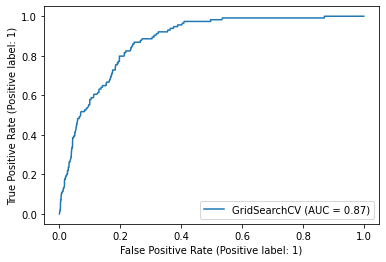

In [235]:
plot_roc_curve(grid_xg, X_val, y_val)

The ROC AUC curve of the XGBoost model (fit on the train val split data) on the validation data. The area under the curve shows how well the model can distinguish between the two classes.  

We do not show the curve for the model that is fit on the full dataset because we do not have the the true labels for the test to plot that.

### Analyse Best Model Coefficients

In [228]:
xgb_best_model['xgb'].get_booster().feature_names = variables

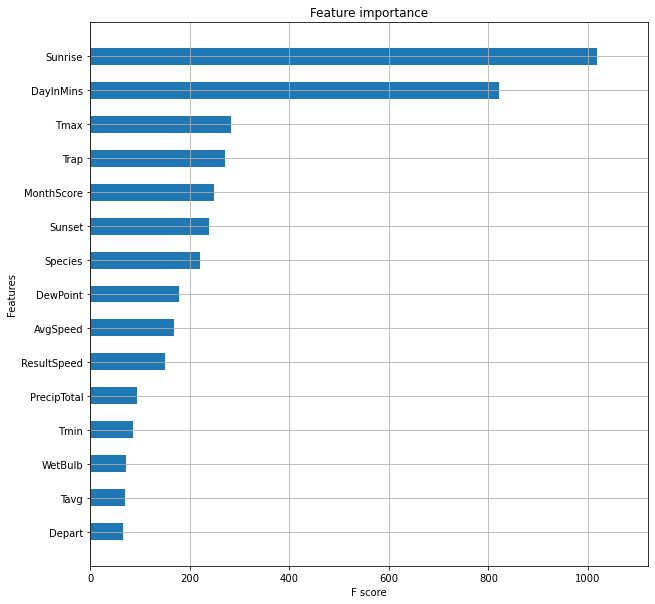

In [229]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

plot_importance(xgb_best_model['xgb'].get_booster(), ax=ax, importance_type="gain", show_values = False, height=0.5);

Sunrise and DayInMins seem to be the strongest features. It is likely that this corresponds with the warmer days which are ideal for mosquito breeding. The Tmax variable also reflects this.

## Cost and Effectiveness

**Cost**                                                                                                                                                                                             
The CDPH conducts mosquito spraying as a measure to kill adult mosquitos and reduce the occurrence of the West Nile Virus.
The spraying begins at dusk and continues through the night. The material being used to control the adult mosquitoes, Zenivex™, is applied at a rate of 1.5 fluid ounces (0.01171875 gallons) per acre. The spray will be applied by licensed mosquito abatement technicians. The cost of Zenivex E4 is about 80 USD dollars per gallon. Given that the total area of Chicago is 606.1 km2 (149 770.572 acres), it would cost $140,409 to cover the entire area. (info from [this source](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes.html)).


There are also biodiversity issues especially when dealing with natural protected areas. We have to prevent at least 19 non-serious case of Wnv to justify the cost. ($7,500 hospitalisation cost). 

**Effect**                                                                                              
          
Based on the exploratory data analysis conducted earlier, there was a lack of evidence to support the claim that mosquito spraying had any effect on reducing WnvPresent. Many of the traps’ locations did not match the spray locations. This made it difficult to verify the effectiveness after spraying. Furthermore, there are only year 2011 and 2013 spraying data with only 10 records of spraying. Out of these 10 sprays, 6 times sprays were conducted in Aug 2013 and early Sept 2013. However, it did not reveal any noticeable decrease in WNV occurrences in Sept 2013.

## Conclusion and Recommendations

Based on the high financial cost of spraying, detriment to the environment, and poor correlation of spraying to the presence of the virus, we recommend CDPH to cut down on spraying as the cost does not justify the benefits derived from it. This is evident from the much higher West Nile Virus presence seen in the year 2013 when spraying was conducted. CDPH should instead spend more effort in educating citizens in predicted areas to reduce mosquito breeding habitats by clearing areas with stale water and cleaning rain gutters, and to wear clothing that provides protection from mosquitos. 

## References

1. https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes.html
2. https://www.cmmcp.org/pesticide-information/pages/zenivex-e4-etofenprox
3. http://www.gfmosquito.com/wp-content/uploads/2013/06/2013-North-Dakota-Bid-Tabulation.pdf
4. https://chicago.cbslocal.com/2017/08/30/spray-mosquitoes-far-south-side-west-nile-prevention/
5. https://datasmart.ash.harvard.edu/news/article/predictive-analytics-guides-west-nile-virus-control-efforts-in-chicago-1152
6. https://www.cdc.gov/westnile/index.html
7. https://cookcountypublichealth.org/communicable-diseases/west-nile-virus/
8. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2929059/)
9. https://www.dekalbhealth.net/envhealth/west-nile-virus/mosquito-life-cycle/ 
10. https://parasitesandvectors.biomedcentral.com/articles/10.1186/1756-3305-7-323